# Predicting Airline Delays

In [356]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import random

import warnings
warnings.filterwarnings("ignore")

In [403]:
flights_all = pd.read_csv('../../__DATA__/2008.csv')
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 5692677 to 2217017
Data columns (total 11 columns):
Month             300000 non-null int64
DayofMonth        300000 non-null float64
DayOfWeek         300000 non-null int64
CRSDepTime        300000 non-null float64
CRSArrTime        300000 non-null float64
UniqueCarrier     300000 non-null object
CRSElapsedTime    299963 non-null float64
Origin            300000 non-null object
Dest              300000 non-null object
Distance          300000 non-null float64
Delayed           300000 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 37.5+ MB


In [404]:
###Binarizing and adding delayed classification feature.
flights_all['Delayed'] = 0
flights_all['TotDelayed'] = flights_all[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']].sum(axis=1)
flights_all.loc[flights_all['TotDelayed'] >= 30, 'Delayed'] = 1
flights_all.loc[flights_all['Diverted'] == 1, 'Delayed'] = 1
flights_all.loc[flights_all['Cancelled'] == 1, 'Delayed'] = 1
    

In [367]:
columns_to_drop = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','TotDelayed',
                   'Cancelled','CancellationCode','TailNum','ArrDelay','DepDelay','DepTime','ArrTime','FlightNum',
                   'ActualElapsedTime', 'Diverted', 'AirTime', 'TaxiIn', 'TaxiOut', 'Year']

flights = resample(flights_all, replace=False, n_samples = 300000).drop(columns=columns_to_drop)

##Dropping Cancelled Flights from the Dataset
#index =(flights[flights['Cancelled'] == 1]).index.dropna().tolist()
#flights = flights.drop(index, axis = 0).drop(columns=['Cancelled','CancellationCode','TaxiIn','TaxiOut'])

In [61]:
len(index)

5873

### Cleaning Considerations

- To eliminate or include cancelled flights as delayed flights. (Most likely include them as delayed flights, or you can try both methods and see how that affects the model) Eliminated cancelled flights because NaN are difficult to deal with.
- Convert time to minute during the day
- Remove Flight Number, Cancellation, CancellationCode, Actual departure and arrival times
- Create CRS Elapsed Time

In [360]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1871565 to 2436373
Data columns (total 11 columns):
Month             300000 non-null int64
DayofMonth        300000 non-null int64
DayOfWeek         300000 non-null int64
CRSDepTime        300000 non-null int64
CRSArrTime        300000 non-null int64
UniqueCarrier     300000 non-null object
CRSElapsedTime    299972 non-null float64
Origin            300000 non-null object
Dest              300000 non-null object
Distance          300000 non-null int64
Delayed           300000 non-null int64
dtypes: float64(1), int64(7), object(3)
memory usage: 27.5+ MB


In [194]:
#flights['Month'].sort_values()

In [183]:
#flights[flights['CRSElapsedTime'].isna() == True]
#flights[flights['Diverted'] == 1].shape

Questions to help move forward:
- How to deal with four different target variables in a regression. Should I combine them? --Simply convert to classification: Cancelled flight count as delayed flights.
- How can I convert hhmm time to mm time?
- Regressing against time? Is that weird at all? I assume not as long as relative scale remains the same.
- How should I classisy Cancelled Flights?

Preprocessing Notes:
- Features to Binarize: Carrier, Origin, Destination, 

In [192]:
import math
math.floor(2350/100)*60 + (2350 % 100)

1430

### Preprocessing Checklist:
- Categorize and Binarize Month by quarters
- Convert hhmm times to mmmm during the day
- Binarize day of the week.
- Binarize Origin, Destination, and Carrier
- Impute CRSElapsedTime Data

In [369]:
flightsPP = flights

#flightsPP['DayOfMonth'] = 4
#flightsPP.loc[flights['DayOfMonth'] <= 23, 'DayOfMonth'] = 3
#flightsPP.loc[flights['DayOfMonth'] <= , 'DayOfMonth'] = 2
#flightsPP.loc[flights['DayOfMonth'] in range(7), 'DayOfMonth'] = 1

#Categorizing days of the month into sequential quarters of the month
flightsPP['DayofMonth'] = np.ceil(flights['DayofMonth']/8)

#Log Transforming features to normalize the data.
flightsPP['Distance'] = np.log(flights['Distance'])
flightsPP['CRSElapsedTime'] = np.log(flights['CRSElapsedTime'])

#converting hhmm time format into pure minutes of the day.
timecats = ['CRSDepTime','CRSArrTime']
for i in timecats:
    mmhh = flights[i]
    flightsPP[i] = np.floor(mmhh/100)*60 + (mmhh % 100)
    
flightsPP = pd.get_dummies(flightsPP, columns = ['DayOfWeek','DayofMonth','UniqueCarrier','Origin','Dest'],
                           prefix = ['DoW','QTRoM','Carrier','Org','Dest'])

flightsPP['CRSElapsedTime'] = flightsPP['CRSElapsedTime'].fillna(flightsPP['CRSElapsedTime'].mean())

In [362]:
flightsPP.shape

(300000, 639)

In [363]:
flightsPP.columns[:50]

Index(['Month', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance',
       'Delayed', 'DoW_1', 'DoW_2', 'DoW_3', 'DoW_4', 'DoW_5', 'DoW_6',
       'DoW_7', 'QTRoM_1.0', 'QTRoM_2.0', 'QTRoM_3.0', 'QTRoM_4.0',
       'Carrier_9E', 'Carrier_AA', 'Carrier_AQ', 'Carrier_AS', 'Carrier_B6',
       'Carrier_CO', 'Carrier_DL', 'Carrier_EV', 'Carrier_F9', 'Carrier_FL',
       'Carrier_HA', 'Carrier_MQ', 'Carrier_NW', 'Carrier_OH', 'Carrier_OO',
       'Carrier_UA', 'Carrier_US', 'Carrier_WN', 'Carrier_XE', 'Carrier_YV',
       'Org_ABE', 'Org_ABI', 'Org_ABQ', 'Org_ABY', 'Org_ACK', 'Org_ACT',
       'Org_ACV', 'Org_ACY', 'Org_ADK', 'Org_ADQ', 'Org_AEX', 'Org_AGS',
       'Org_AKN'],
      dtype='object')

In [364]:
#Are any columns unfilled in the flightsPP dataframe?
flightsPP.isna().sum().sum() > 1

False

### Model Iterations

In [280]:
# X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

### Data Exploration

(array([  151.,  2445., 11614., 30226., 54085., 74336., 71566., 37055.,
        18005.,   517.]),
 array([3.4339872 , 3.9415449 , 4.4491026 , 4.95666029, 5.46421799,
        5.97177568, 6.47933338, 6.98689108, 7.49444877, 8.00200647,
        8.50956416]),
 <a list of 10 Patch objects>)

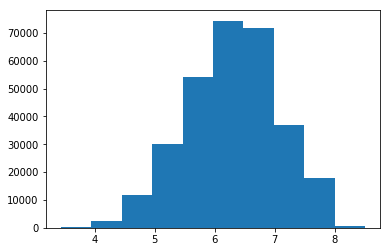

In [371]:
plt.hist(flightsPP['Distance'])

### Dimensionailty Reduction

In [372]:
from sklearn.decomposition import PCA

X = flightsPP.loc[:, ~(flightsPP.columns).isin(['Delayed'])]

pca = PCA(n_components = 10)
PCs = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[8.93249848e-01 1.06650803e-01 7.12955114e-05 5.09594021e-06
 1.01122381e-06 9.16255696e-07 9.04977029e-07 9.04267285e-07
 9.00754670e-07 8.65285774e-07]


## Model Training Iterations

Overall Strategy:

This is a classification problem, so models that might work include Naive Bayes, KNN, SVM, Logistic Regression, Random Forest, and Gradient Boosting Models (Essentially all of them). The total proportion of flights that were either delayed, cancelled, or diverted is 15.4% so the data is fairly imbalanced. We will monitor type 1 and type 2 errors as a more robust way to measure the performance of the models.

What's an interesting feature that captures the interaction between time and origin/destination.

In [373]:
flightsPP['Delayed'].mean()

0.15434333333333333

### Iteration 1: Logistic Regression

In [374]:
from sklearn.linear_model import LogisticRegression

X = PCs
Y = flightsPP['Delayed']

clf = LogisticRegression(solver='sag', penalty='none')
clf.fit(X,Y)
print(cross_val_score(clf, X, Y, cv=10))

preds = clf.predict(X)
pred_counts = (preds == Y).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
#conmax = confusion_matrix(Y,preds)
#print('\nType 2 Error / Unnoticed Fraud: {}'.format(conmax[1,0]/conmax[1].sum()))
#print('\nType 1 Error / Flagged Non-Fraud: {}'.format(conmax[0,1]/conmax[0].sum()))

[0.84563848 0.84563848 0.84563848 0.84566667 0.84566667 0.84566667
 0.84566667 0.84566152 0.84566152 0.84566152]
Overall Accuracy: 0.8456566666666666
46303 total misclassified out of 300000.


In [325]:
conmax = confusion_matrix(Y,preds)
print(conmax)

[[254091  45909]
 [     0      0]]


In [334]:
set(list(preds))

{0}

### Iteration 2: Random Forest Classifier

In [352]:
from sklearn.ensemble import RandomForestClassifier

X = PCs
Y = flightsPP['Delayed']

clf = RandomForestClassifier()
clf.fit(X,Y)
print(cross_val_score(clf, X, Y, cv=10))

preds = clf.predict(X)
pred_counts = (preds == Y).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
conmax = confusion_matrix(Y,preds)
print('\nType 2 Error / Unflagged Delayed Flights: {}'.format(conmax[1,0]/conmax[1].sum()))
print('\nType 1 Error / Incorrectly Flagged On-Time: {}'.format(conmax[0,1]/conmax[0].sum()))

[0.84413853 0.8435     0.84426667 0.845      0.84466667 0.84336667
 0.84556667 0.846      0.84203333 0.84476149]
Overall Accuracy: 0.97943
6171 total misclassified out of 300000.

Type 2 Error / Unflagged Delayed Flights: 0.13204382582935809

Type 1 Error / Incorrectly Flagged On-Time: 0.00042898016852230107


In [342]:
conmax

array([[254091,      0],
       [ 45909,      0]])

Tuning Parameters seems to flatten all the predictions to 0 such that no flights are predicted as delayed. But so far the prediction error of delayed/cancelled/diverted flights at 12.85% is very good.

Despite the first two Principal Component features capturing 99.9% of the variability, the Random Forest classifier decreases its type two error by 7% when the number of PC's changes from 2 to 10, so keeping a larger number of PC's for this model is important.

We will try a gradient boosted model next.

### Iteration 3: Gradient Boosting Model

In [353]:
from sklearn.ensemble import GradientBoostingClassifier

X = PCs
Y = flightsPP['Delayed']

clf = GradientBoostingClassifier()
clf.fit(X,Y)
print(cross_val_score(clf, X, Y, cv=5))

preds = clf.predict(X)
pred_counts = (preds == Y).value_counts()
print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
conmax = confusion_matrix(Y,preds)
print('\nType 2 Error / Unflagged Delayed Flights: {}'.format(conmax[1,0]/conmax[1].sum()))
print('\nType 1 Error / Incorrectly Flagged On-Time: {}'.format(conmax[0,1]/conmax[0].sum()))

[0.84731921 0.84751667 0.8472     0.84735    0.84736412]
Overall Accuracy: 0.8472666666666666
45820 total misclassified out of 300000.

Type 2 Error / Unflagged Delayed Flights: 0.9972554401097824

Type 1 Error / Incorrectly Flagged On-Time: 0.00014561712142500128


In [347]:
conmax

array([[253965,    126],
       [ 45632,    277]])

Overall, the best model that I could configure for predicting airlines involved the random forest classifier. I found that the default sklearn parameters returned the highest accuracy rate while reducing the most type 2 errors of marking delayed flights as non-delayed.

The only concern was that for both Gradient Boosting Classifiers and other parameter settings for the Random Forest Classifier, the modeled produced predictions that all seemed to flatten out to non-delayed (negative) outcomes for each flight - virtually no flights were predicted to have been delayed. The unstable nature of the ensemble models is concerning, and I'm unsure how to diagnose this modeling behavior. Partcularing witht he random forest classifier, increasing the estimators and depth of the model seemed to overfit the model; however, cross-validating the model returned consistent accuracies across folds despite having leaned too far in the direction of classifying all flights as undelayed. Given this, it's perhaps best to oversample delayed flights values and see how this oversampling affects the accuracy of my models.

The logistic regression model did not seem to have any predictive power: it's accuracy score was no better than just guessing based on the percentage of flights that were delayed.

# Iteration Series: With Oversampled Sample

In [412]:
DelayedFlights = resample(flights_all[flights_all['Delayed'] == 1], replace=False, n_samples = 150000).drop(columns=columns_to_drop)
OnTimeFlights = resample(flights_all[flights_all['Delayed'] == 0], replace=False, n_samples = 150000).drop(columns=columns_to_drop)
flights2 = pd.concat([DelayedFlights,OnTimeFlights])

flightsPP2 = flights2

#Categorizing days of the month into sequential quarters of the month
flightsPP2['DayofMonth'] = np.ceil(flights2['DayofMonth']/8)

#Log Transforming features to normalize the data.
flightsPP2['Distance'] = np.log(flights2['Distance'])
flightsPP2['CRSElapsedTime'] = np.log(flights2['CRSElapsedTime'])

#converting hhmm time format into pure minutes of the day.
timecats = ['CRSDepTime','CRSArrTime']
for i in timecats:
    mmhh = flights2[i]
    flightsPP2[i] = np.floor(mmhh/100)*60 + (mmhh % 100)
    
#binarizing categories
flightsPP2 = pd.get_dummies(flightsPP2, columns = ['DayOfWeek','DayofMonth','UniqueCarrier','Origin','Dest'],
                           prefix = ['DoW','QTRoM','Carrier','Org','Dest'])

#Imputing missing values
flightsPP2['CRSElapsedTime'] = flightsPP2['CRSElapsedTime'].fillna(flightsPP2['CRSElapsedTime'].mean())


In [383]:
#Running PCA to reduce dimensions:
X = flightsPP2.loc[:, ~(flightsPP2.columns).isin(['Delayed'])]

pca = PCA(n_components = 10)
PCs = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[8.76934012e-01 1.22944519e-01 8.56344897e-05 5.53199763e-06
 1.81162927e-06 1.77209218e-06 1.48763294e-06 1.13974807e-06
 1.00306865e-06 9.91212478e-07]


In [432]:
# Creating function/template to run any model

#X = PCs
#Y = flightsPP['Delayed']
#clf = GradientBoostingClassifier()

def FlightCLF(classifier, Xtrain, Ytrain, cv = 5):
    clf.fit(Xtrain,Ytrain)
    print('Cross Validation Scores:')
    print(cross_val_score(clf, Xtrain, Ytrain, cv=cv))
    
    preds = clf.predict(Xtrain)
    pred_counts = (preds == Ytrain).value_counts()
    print('Overall Accuracy: {}'.format(pred_counts[1]/pred_counts.sum()))
    print('{} total misclassified out of {}.'.format(pred_counts[0],pred_counts.sum()))
    conmax = confusion_matrix(Ytrain,preds)
    print('\nType 2 Error / Unflagged Delayed Flights: {}'.format(conmax[1,0]/conmax[1].sum()))
    print('\nType 1 Error / Incorrectly Flagged On-Time: {}'.format(conmax[0,1]/conmax[0].sum()))

### Iteration 4: Logistic Oversampling

In [433]:
X = PCs
Y = flightsPP2['Delayed']
clf = LogisticRegression(solver = 'sag', penalty='none')

FlightCLF(clf,X,Y)

Cross Validation Scores:
[0.5 0.5 0.5 0.5 0.5]
Overall Accuracy: 0.5
150000 total misclassified out of 300000.

Type 2 Error / Unflagged Delayed Flights: 0.34563333333333335

Type 1 Error / Incorrectly Flagged On-Time: 0.6543666666666667


Logistic Regression really isn't working for this model

### Iteration 5: Random Forest Model

In [436]:
X = PCs
Y = flightsPP2['Delayed']
clf = RandomForestClassifier(n_estimators = 50, max_depth = 5, criterion='entropy')

FlightCLF(clf,X,Y)

Cross Validation Scores:
[0.5 0.5 0.5 0.5 0.5]
Overall Accuracy: 0.5
150000 total misclassified out of 300000.

Type 2 Error / Unflagged Delayed Flights: 0.48600666666666664

Type 1 Error / Incorrectly Flagged On-Time: 0.5139933333333333


Oversampling, unfortunately is not working very well.